In [19]:
import os
import glob
import copy

import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import psignifit as ps
import _pickle as pkl

from psignifit import getSigmoidHandle as getSig
import analyze2p.objects.neurometric as nm

In [2]:
import importlib

In [3]:
import analyze2p.plotting as pplot

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
src_dir = os.path.join('/n/coxfs01/behavior-data/threeport')
morph_dir = os.path.join(src_dir, 'processed/morphs')
fit_dir = os.path.join(morph_dir, 'fits')

In [74]:
fig_dir = os.path.join(fit_dir, 'figures')
if not os.path.exists(os.path.join(fig_dir)):
    os.makedirs(os.path.join(fig_dir))


In [113]:
datafile = os.path.join(morph_dir, 'data_summaries.pkl')
with open(datafile, 'rb') as f:
    ddict = pkl.load(f, encoding='latin1')
counts = ddict['counts']
pass_animals = ddict['pass_animals']
data = ddict['data']
all_animals = counts['animalid'].unique()
print('%i/%i animals pass with criterion 0.70' % (len(pass_animals), len(all_animals)))

10/13 animals pass with criterion 0.70


# Load fits

In [114]:
max_x = counts['morphlevel'].max()
criterion=0.70
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']


In [229]:
#prefix = 'fits_m22-gauss'
prefix = 'fits_L23-gauss'
aggr_fpath = glob.glob(os.path.join(fit_dir, 'aggr_%s*.pkl' % prefix))[0]

In [230]:
fit_dir

'/n/coxfs01/behavior-data/threeport/processed/morphs/fits'

In [231]:
fpaths = glob.glob(os.path.join(fit_dir, '%s*.pkl' % prefix))
print(len(fpaths))
results={}
d_=[]
for fn in fpaths:
    animalid = os.path.splitext(os.path.split(fn)[-1])[0].split(prefix)[-1][1:]
    with open(fn, 'rb') as f:
        res = pkl.load(f)
    res['options']['sigmoidHandle'] = getSig.getSigmoidHandle(res['options'])
    df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[animalid]).T
    try:
        thr = ps.getThreshold(res, 0.5, 0)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res, ps.getThreshold(res, 0.5, 1)[0]) # Slope at given stimulus level
    except Exception as e:
        thr=None
        slp=None
    [thr_0,CI0] = ps.getThreshold(res,0.25,1)
    [thr_1,CI1] = ps.getThreshold(res,0.75,1)
    jnd = thr_1-thr_0
    df_['jnd'] = jnd
    df_['slope'] = slp
    df_['thr_scaled'] = thr
    df_['animalid'] = animalid
    d_.append(df_)
    results[animalid] = res
FITS = pd.concat(d_, axis=0)

13


<IPython.core.display.Javascript object>


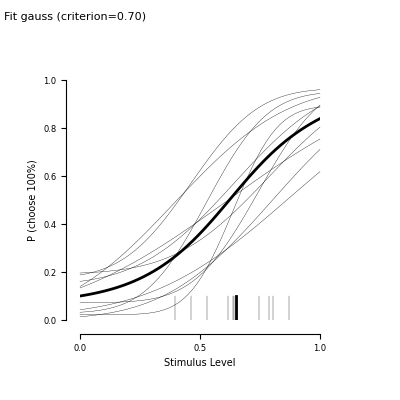

AG10 [0.79 1.01 0.   0.19 0.07]
AG2 [0.64 0.48 0.11 0.02 0.  ]
AG4 [0.8  1.17 0.   0.   0.  ]
AG6 [0.87 1.49 0.   0.02 0.06]
AG8 [0.74 0.69 0.   0.07 0.  ]
AG9 [0.62 1.83 0.   0.   0.  ]
AN4 [0.46 0.73 0.03 0.17 0.  ]
AN5 [0.64 1.03 0.   0.14 0.  ]
AN6 [0.39 1.21 0.02 0.   0.  ]
AN7 [0.53 0.66 0.05 0.03 0.  ]
/n/coxfs01/behavior-data/threeport/processed/morphs/fits/figures fits_L23-gauss_curves


In [232]:
%matplotlib notebook
max_x=1
mean_color='k'
mean_lw = 2
thresh_height=0.1
npoints=50
opts = nm.default_options(yesno=True)
sigmoid_=opts['sigmoidName']
fitvs=[]

fig, ax = pl.subplots(figsize=(4,4))
for animalid, res in results.items():
    if animalid not in pass_animals:
        continue
    print(animalid, res['Fit'].round(2))
    ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=0.25, 
                            plotAsymptote=False,
                            thresh_height=thresh_height, fontSize=6, labelSize=7,
                            npoints=npoints, extrapolLength=0, )
    fh = getSig.getSigmoidHandle(opts)
    xv, fv = nm.fit_sigmoid(res['Fit'], fh, xmin=0, xmax=max_x)
    fitvs.append(fv)
    
fitvs = np.array(fitvs)
mean_fit = np.mean(fitvs, axis=0)

ax.plot(xv, mean_fit, mean_color, lw=mean_lw)
mean_thr = FITS[FITS.animalid.isin(pass_animals)]['threshold'].mean()
ax.plot([mean_thr, mean_thr], [0, thresh_height], color=mean_color, lw=mean_lw)
ax.set_box_aspect(1)

# formatting
ax.set_xlim([0, max_x])
ax.set_xticks(np.linspace(0, max_x, 3))
pl.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)
sns.despine(trim=True, offset=10)
ax.set_ylabel('P (choose 100%)')
fig.text(0.01, 0.95, 'Fit %s (criterion=%.2f)' % (sigmoid_, criterion), fontsize=8)

figname = '%s_curves' % prefix
pl.savefig(os.path.join(fig_dir, '%s.svg' % figname))
print(fig_dir, figname)

### Fits

In [233]:
passdf = FITS[FITS.animalid.isin(pass_animals)]

In [234]:
n_rats=len(pass_animals)

<IPython.core.display.Javascript object>


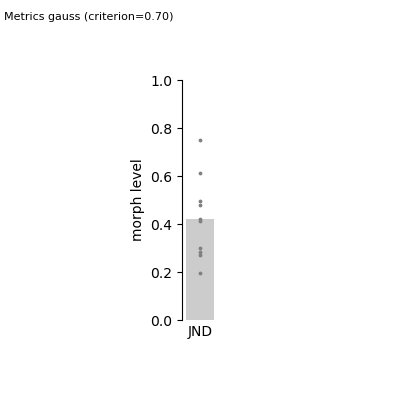

/n/coxfs01/behavior-data/threeport/processed/morphs/fits/figures fits_L23-gauss_params


In [238]:
plot_params =['jnd'] # ['threshold', 'jnd']
fig, ax = pl.subplots(figsize=(4,4))

for ai, param in enumerate(plot_params):
    ax.bar(x=ai, height=passdf[param].mean(), color=[0.8]*3, zorder=-100)
    ax.scatter([ai]*n_rats, passdf[param].values, color=[0.5]*3, s=3, zorder=100)
ax.set_xticks([0])
ax.set_xticklabels(['JND'], rotation=0)
ax.tick_params(which='both', axis='x', size=0)

ax.set_box_aspect(8)
ax.set_ylim([0,1])
ax.set_ylabel('morph level')
sns.despine(bottom=True, offset=2)
pl.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)

fig.text(0.01, 0.95, 'Metrics %s (criterion=%.2f)' % (sigmoid_, criterion), fontsize=8)

figname = '%s_params' % prefix
pl.savefig(os.path.join(fig_dir, '%s.svg' % figname))
print(fig_dir, figname)

In [248]:
import pingouin as pg

In [249]:
passdf.describe()

,threshold,width,lambda,gamma,eta,jnd,slope,thr_scaled
count,10.000000,10.000000,1.000000e+01,10.000000,1.000000e+01,10.000000,10.000000,10.000000
mean,0.648820,1.029184,2.129707e-02,0.064895,1.294949e-02,0.422028,1.333275,0.628394
std,0.155314,0.415254,3.492307e-02,0.075946,2.730078e-02,0.170279,0.520185,0.151818
min,0.393935,0.476903,5.479165e-09,0.000083,3.009425e-08,0.195559,0.717321,0.404760
25%,0.549806,0.702459,2.718414e-07,0.005220,8.685806e-08,0.288051,1.053439,0.543602
50%,0.641199,1.017267,1.549867e-04,0.025292,2.018010e-07,0.417141,1.108196,0.637179
75%,0.775970,1.200642,3.152967e-02,0.126226,5.241508e-07,0.492336,1.674328,0.716402
max,0.870924,1.829436,1.072818e-01,0.191586,6.530542e-02,0.750180,2.395963,0.861824


In [250]:
posthoc='fdr_bh'
sts = pg.pairwise_ttests(data=plotdf, dv='per_correct', between='type',
                   parametric=False, padjust=posthoc, effsize='eta-square')
sts

NameError: name 'plotdf' is not defined

In [140]:
for (a, o, s), g in data.groupby(['animalid', 'objectid', 'session']):
    df_ = g.sort_values(by=['time'])
    df_['trial'] = np.arange(0, len(df_))
    data.loc[df_.index, 'trial'] = df_['trial']
    

In [209]:
default_views = data[(data['size']==40) & (data['depth_rotation']==0)
                    & (data.animalid.isin(pass_animals))].copy()

In [211]:
ign = ['name', 'light_position', 'x_rotation', 'outcome', 'duration', 'trial',
       'outcome_time', 'response', 'response_time','suffix', 'time', 'session',
       'sessionid']
cols = [c for c in data.columns if c not in ign]
d_=[]
for (a, o, s, m), g \
    in default_views.groupby(['animalid', 'objectid', 'session', 'morphlevel']):
    n_trials = len(g)
    n_success = len(g[g['outcome']=='success'])
    pc_ = n_success/n_trials
    mean_rt = g['response_time'].mean()
    
    df_ = g[cols].drop_duplicates().reset_index(drop=True)
    df_['perc_correct'] = pc_
    df_['mean_rt'] = mean_rt
    df_['n_trials'] = n_trials
    d_.append(df_)
scores = pd.concat(d_)
scores

,depth_rotation,no_feedback,object,pos_x,pos_y,rotation,size,animalid,cohort,objectid,phase,portmap,morphlevel,perc_correct,mean_rt,n_trials
0,0,False,1,0.0,0.0,0.0,40.0,AG10,AG,1,7,0,0,0.800000,0.714012,25
0,0,False,1,0.0,0.0,0.0,40.0,AG10,AG,1,7,0,0,0.791667,0.686334,24
0,0,False,1,0.0,0.0,0.0,40.0,AG10,AG,1,7,0,0,0.953488,0.537166,43
0,0,False,1,0.0,0.0,0.0,40.0,AG10,AG,1,7,0,0,0.926829,0.518017,41
0,0,False,1,0.0,0.0,0.0,40.0,AG10,AG,1,7,0,0,0.897436,0.574082,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,False,morph,0.0,0.0,0.0,40.0,AN7,AN,morph,7,1,10,1.000000,0.837145,16
0,0,False,morph,0.0,0.0,0.0,40.0,AN7,AN,morph,7,1,12,0.933333,0.943403,15
0,0,False,morph,0.0,0.0,0.0,40.0,AN7,AN,morph,7,1,14,1.000000,0.774907,8
0,0,False,morph,0.0,0.0,0.0,40.0,AN7,AN,morph,7,1,17,0.866667,0.835577,15


In [239]:
anchors = scores[(scores['morphlevel'].isin([0, 22]))].copy()
anchors.head()

,depth_rotation,no_feedback,object,pos_x,pos_y,rotation,size,animalid,cohort,objectid,phase,portmap,morphlevel,perc_correct,mean_rt,n_trials
0,0,False,1,0.0,0.0,0.0,40.0,AG10,AG,1,7,0,0,0.800000,0.714012,25
0,0,False,1,0.0,0.0,0.0,40.0,AG10,AG,1,7,0,0,0.791667,0.686334,24
0,0,False,1,0.0,0.0,0.0,40.0,AG10,AG,1,7,0,0,0.953488,0.537166,43
0,0,False,1,0.0,0.0,0.0,40.0,AG10,AG,1,7,0,0,0.926829,0.518017,41
0,0,False,1,0.0,0.0,0.0,40.0,AG10,AG,1,7,0,0,0.897436,0.574082,39


In [240]:
object_colors={'1': 'r', '2': 'b'}

<IPython.core.display.Javascript object>


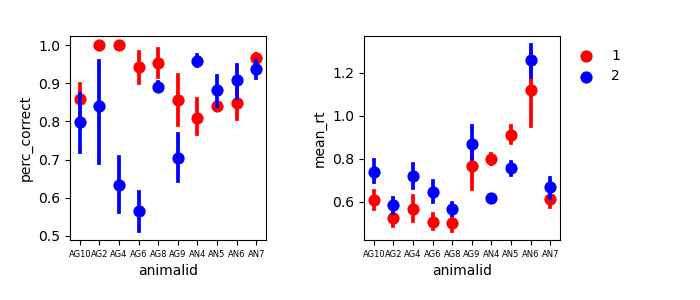

In [241]:

fig, axn = pl.subplots(1,2, figsize=(7,3))
for ax, metric in zip(axn.flat, ['perc_correct', 'mean_rt']):
    sns.pointplot(x='animalid', y=metric, data=anchors, ax=ax,
                 join=False, hue='objectid', palette=object_colors)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
    ax.legend_.remove()
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.8, wspace=0.5, bottom=0.2)


In [242]:
means_by_rat = anchors.groupby(['animalid', 'objectid', 'morphlevel', 'portmap']).mean().reset_index()

In [243]:
passdf

,threshold,width,lambda,gamma,eta,jnd,slope,thr_scaled,animalid
AG10,0.786510,1.008403,5.479165e-09,0.191586,6.530542e-02,0.413507,1.052124,0.694081,AG10
AG2,0.638721,0.476903,1.072818e-01,0.022069,5.957917e-07,0.195559,2.395963,0.656548,AG2
AG4,0.803273,1.167329,1.686528e-07,0.001704,8.926838e-08,0.478676,1.122363,0.802514,AG4
AG6,0.870924,1.490850,3.450953e-08,0.015769,6.418791e-02,0.611339,0.866424,0.861824,AG6
AG8,0.744350,0.692684,5.814075e-07,0.072002,2.042160e-07,0.284042,1.758245,0.723843,AG8
AG9,0.617866,1.829436,6.401648e-07,0.000083,3.092284e-07,0.750180,0.717321,0.617809,AG9
AN4,0.461828,0.731785,3.427200e-02,0.172509,1.993860e-07,0.300076,1.422580,0.412848,AN4
AN5,0.643678,1.026131,3.093332e-04,0.144301,4.319882e-08,0.420776,1.094028,0.577374,AN5
AN6,0.393935,1.211747,2.330269e-02,0.000413,8.605462e-08,0.496890,1.057381,0.404760,AN6
AN7,0.527120,0.656573,4.780348e-02,0.028514,3.009425e-08,0.269235,1.846319,0.532344,AN7


In [244]:
d1 = means_by_rat.sort_values(by='animalid')\
            [means_by_rat['objectid']=='1'].reset_index(drop=True)
d2 = means_by_rat.sort_values(by='animalid')\
            [means_by_rat['objectid']=='2'].reset_index(drop=True)
diffdf = pd.DataFrame({'response_time': d2['mean_rt']-d1['mean_rt'],
              'accuracy': d2['perc_correct'] - d1['perc_correct'],
              'animalid': d2['animalid'],
            'portmap': d2['portmap']}
            )

resdf = pd.merge(passdf, diffdf, on=['animalid'])

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


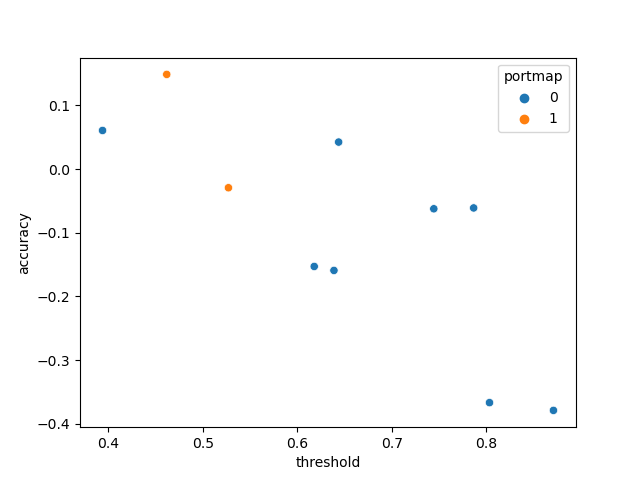

<AxesSubplot:xlabel='threshold', ylabel='accuracy'>

In [245]:
fig, ax = pl.subplots()
sns.scatterplot(x='threshold', y='accuracy', data=resdf, hue='portmap', ax=ax)